# healpy tutorial

Followed from https://healpy.readthedocs.io/en/latest/tutorial.html.

In [122]:
import matplotlib.pyplot as plt
%matplotlib inline

`inline` displays the plots inside the Jupyter notebook.

In [123]:
import numpy as np
import healpy as hp

## NSIDE and ordering

`NSIDE` is the resolution of the map, usually powers of 2.

In [124]:
NSIDE = 64
print(
    "Approximate resolution at NSIDE {} is {:.2} deg.".format(
        NSIDE, hp.nside2resol(NSIDE, arcmin=True) / 60
    )
)

Approximate resolution at NSIDE 64 is 0.92 deg.


`healpy.pixelfunc.nside2npix` gives the amount of pixels NPIX of the map. Also works with simply `hp.nside2npix`.

In [125]:
NPIX = hp.pixelfunc.nside2npix(NSIDE)
print(NPIX)

49152


The default ordering of the pixels is a mode called RING and it looks like this:

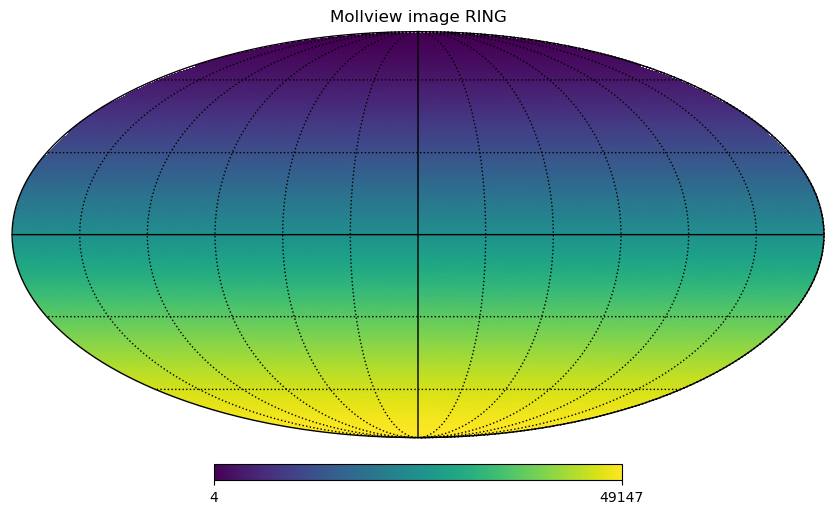

In [126]:
m = np.arange(NPIX)
hp.mollview(m, title="Mollview image RING")
hp.graticule()

`mollview` displays the map in a Mollview projection and `graticule` adds the grid.

The standard coordinates are the **colatitude** $\theta$, the complementary angle of latitude, which is 0 at the North Pole, $\pi$/2 at the equator and $\pi$ at the South Pole. The **longitude** $\phi$ is between 0 and $2\pi$, with 0 being at the center of the map, and the value increasing to the left, continuing on the right after the limit has been reached.

These angles can be converted into vectors via `ang2vec`.

In [127]:
vec = hp.ang2vec(np.pi / 2, np.pi * 5/4)
print(vec)

[-7.07106781e-01 -7.07106781e-01  6.12323400e-17]


We can visualize it by looking at the pixels within 10 degrees of the chosen point.

In [128]:
ipix_disc = hp.query_disc(nside=NSIDE, vec=vec, radius=np.radians(10))

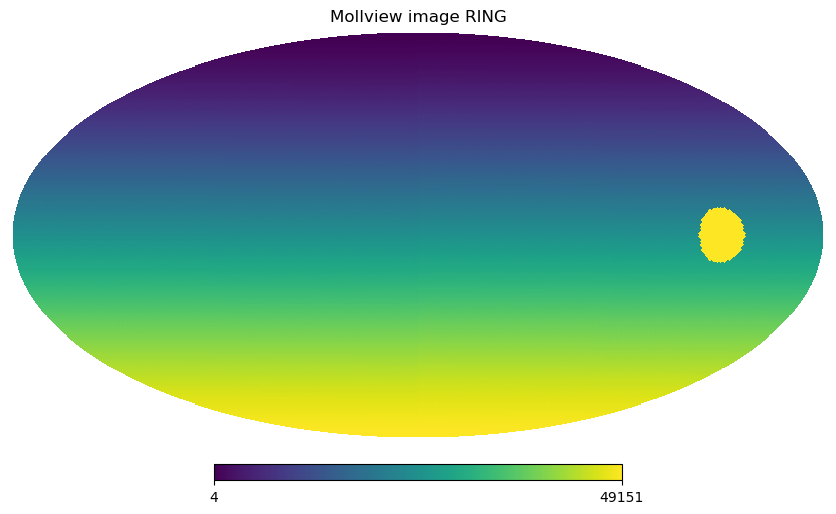

In [129]:
m = np.arange(NPIX)
m[ipix_disc] = m.max()
hp.mollview(m, title="Mollview image RING")

We can get the colatitude and the longitude from the pixels using `pix2ang`.

In [130]:
theta, phi = np.degrees(hp.pix2ang(nside=NSIDE, ipix=[0, 1, 2, 3, 4]))

In [131]:
theta

array([0.73097071, 0.73097071, 0.73097071, 0.73097071, 1.46197116])

In [132]:
phi

array([ 45. , 135. , 225. , 315. ,  22.5])

The first 4 pixels are all at the same latitude, and the 5th one is already part of a new ring.

The other ordering option is called NESTED, whcih is very efficient for map domain operations, because scaling up and down maps is achieved just multiplying and rounding pixel indices. They are ordered as follows:

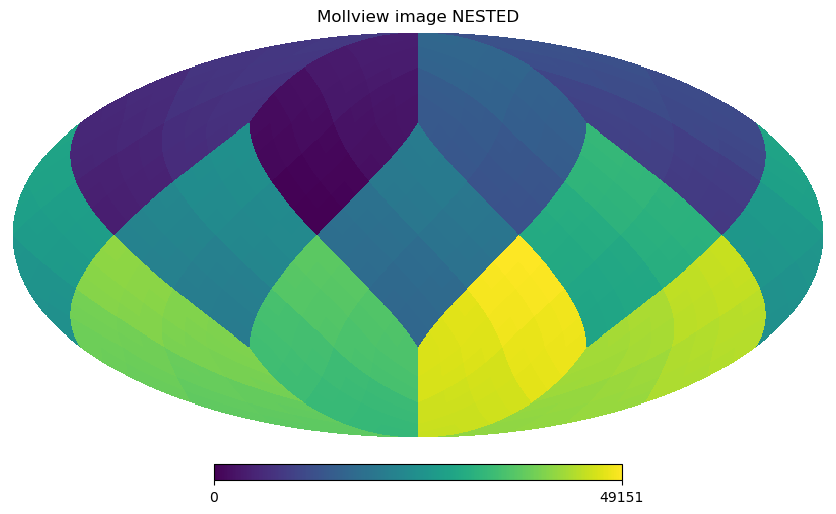

In [133]:
m = np.arange(NPIX)
hp.mollview(m, nest=True, title = "Mollview image NESTED")

## Reading and writing maps to file

In [134]:
wmap_map_I = hp.read_map("data/wmap_band_iqumap_r9_7yr_W_v4.fits")

By default, `read_map` loads the first column. For reading other columns, specify the `field` keyword.

`write_map` writes a map to disk in FITS format. If the input map is a list of 3 maps, they are writte to a single file as I, Q, U polarization components. I, Q, U are the Stokes parameters, which are a set of values that describe the polarization state of electromagnetic radiation, such as light. I is intensity, Q is linear polarization (the difference in intensity between horizontally and vertically polarized light; a positive Q indicates more horizontal polarization and a negative Q indicates more vertical polarization), and U is also linear polarization (the difference in intensity between linearly polarized light (all electric field vectors are confined to a signle plane, perpendicular to the direction of propagation) at +45 degrees and -45 degrees relative to a reference direction).

In [135]:
hp.write_map("output/my_map.fits", wmap_map_I, overwrite=True)

setting the output map dtype to [dtype('>f4')]


## Visualization

Coordinate transformation is supported with `coord`. In the example we do a Galactic (celestial coordinate system that is based on the plane of our Milky Way galaxy) to ecliptic coordinate (based on the plane of Earth's orbit around the Sun) transformation. `norm=hist` sets a histogram equalized color scale (enhanced constrast, normalized). `xsize` increases the size of the image. `graticule` adds meridians and parallels.

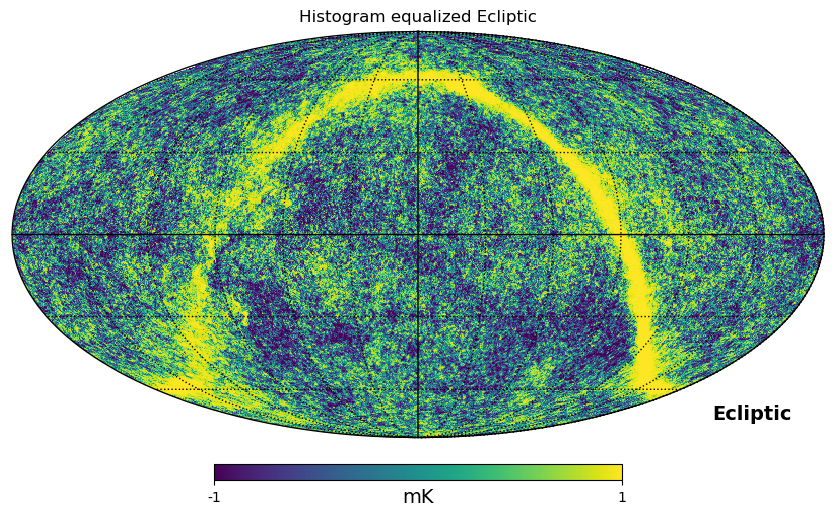

In [136]:
hp.mollview(wmap_map_I,
            coord=["G", "E"],
            title="Histogram equalized Ecliptic",
            unit="mK",
            norm="hist",
            min=-1,
            max=1
            )
hp.graticule()

`gnomview` gives a gnomonic projection (portion of a sphere onto a flat plane) around a position specified by `rot`. `xsize` and `ysize` change the dimension of the sky patch.

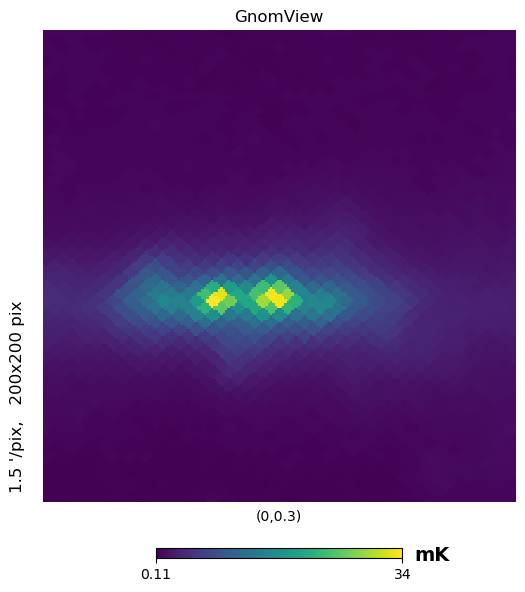

In [137]:
hp.gnomview(wmap_map_I, 
            rot=[0, 0.3],
            title="GnomView",
            unit="mK",
            format="%.2g"
            )

## Masked map, partial maps

By convention, HEALPIX uses -1.6375 * 10^30 to mark invalid or unseen pixels. They are stored in `healpy` as the constant `UNSEEN`.

All `healpy` functions automatically deal with maps with `UNSEEN` pixels, but there is an alternative way to deal with them, based on the numpy `MaskedArray` class. `hp.ma` loads a map as a masked array. By convention, the mask is 0 where the data are masked. However, numpy defines data masked when the mask is True, so it is necessary to flip the mask.

In [138]:
mask = hp.read_map("data/wmap_temperature_analysis_mask_r9_7yr_v4.fits").astype(np.bool_)
wmap_map_I_masked = hp.ma(wmap_map_I)
wmap_map_I_masked.mask = np.logical_not(mask)

Filling a masked array fills the `UNSEEN` values and returns a standard array that can be used by `mollview`. `compressed()` instead removes all the masked pixels and returns a standard array that can be used for example by the matplotlib `hist()` function.

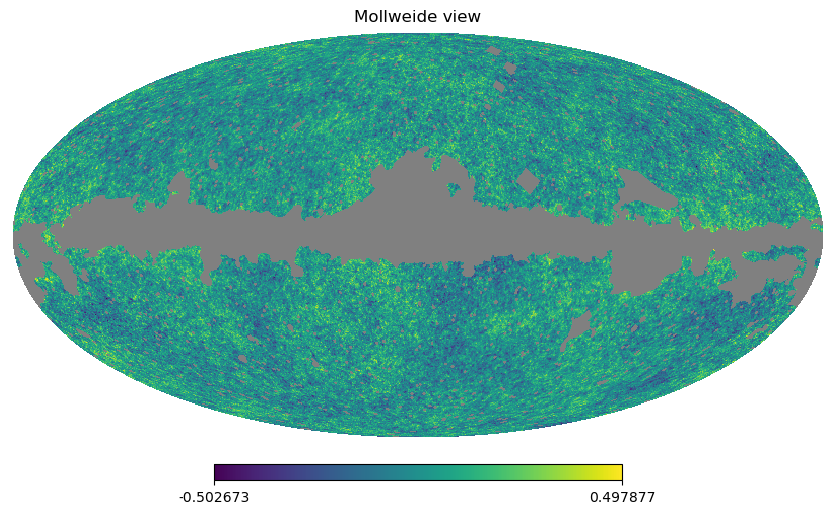

In [139]:
hp.mollview(wmap_map_I_masked.filled())

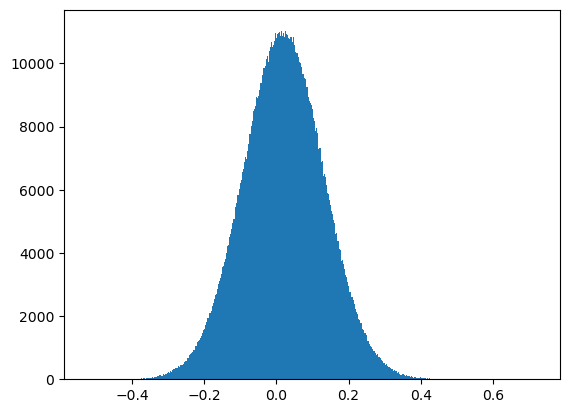

In [140]:
plt.hist(wmap_map_I_masked.compressed(), bins=1000);

## Spherical Harmonics transforms

`hp.anafast` computes the angular power spectrum (distribution of variations or fluctuations over a spherical surface) of a map.

In [141]:
LMAX = 1024
cl = hp.anafast(wmap_map_I_masked.filled(), lmax=LMAX)
ell = np.arange(len(cl))

So we can plot a normalized CMB spectrum ($C_l$) and write it to disk:

<>:3: SyntaxWarning: invalid escape sequence '\e'
<>:4: SyntaxWarning: invalid escape sequence '\e'
<>:3: SyntaxWarning: invalid escape sequence '\e'
<>:4: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_3209767/1056781897.py:3: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel("$\ell$")
/tmp/ipykernel_3209767/1056781897.py:4: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel("$\ell(\ell+1)C_{\ell}$")


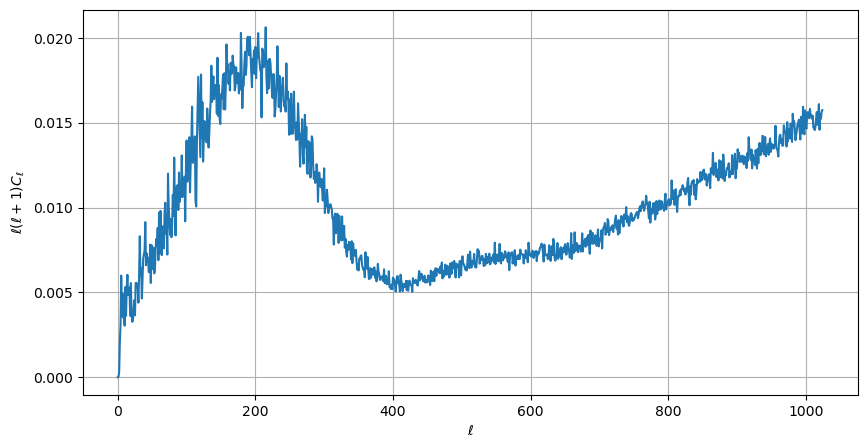

In [142]:
plt.figure(figsize=(10,5))
plt.plot(ell, ell * (ell + 1) * cl)
plt.xlabel("$\ell$")
plt.ylabel("$\ell(\ell+1)C_{\ell}$")
plt.grid()
hp.write_cl("output/cl.fits", cl, overwrite=True)

Gaussian beam ma smoothing is provided by `hp.smoothing`:

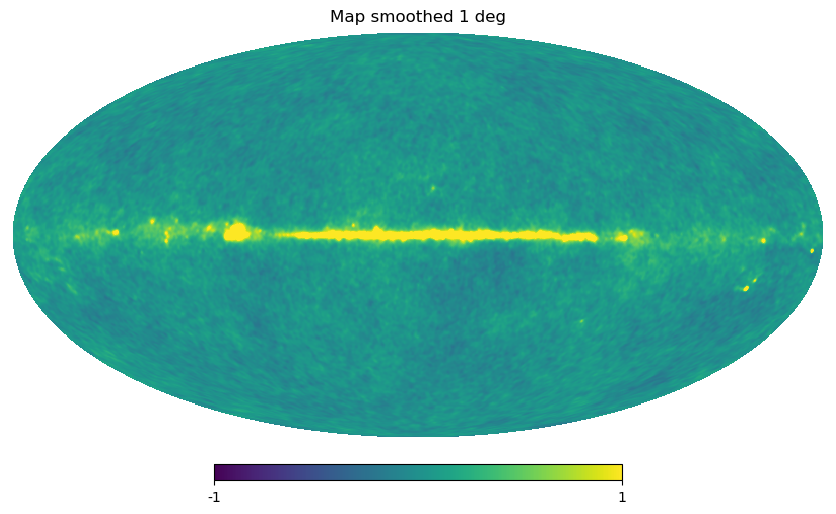

In [147]:
wmap_map_I_smoothed = hp.smoothing(wmap_map_I,
                                   fwhm=np.radians(1.)
                                   )
hp.mollview(wmap_map_I_smoothed,
            min=-1,
            max=1,
            title="Map smoothed 1 deg"
            )